In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, tqdm, glob
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum
from jaxpm.utils import _initialize_pk
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel, invnabla_kernel
from jaxpm import camels

jax.devices("gpu")

[cuda(id=0)]

In [3]:
parts_per_dim = 64
# parts_per_dim = 128
# parts_per_dim = 256
mesh_per_dim = parts_per_dim
# mesh_per_dim = 512
mesh_shape = [mesh_per_dim] * 3
box_size = [float(mesh_per_dim)] * 3

In [8]:
hydro_dict = camels.load_CV_snapshots(
    "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0",
    mesh_per_dim,
    # parts_per_dim,
    i_snapshots=[-1],
)

cosmo = hydro_dict["cosmo"]
scales = hydro_dict["scales"]

gas_pos = hydro_dict["gas_poss"]
gas_vel = hydro_dict["gas_vels"]
gas_mass = hydro_dict["gas_masss"]
gas_U = hydro_dict["gas_Us"]
gas_P = hydro_dict["gas_Ps"]

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5']
Using all particles


loading snapshots: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

4.5478253e+16
2690158000000000.0


In [10]:
(25/64)**3

0.059604644775390625

In [5]:
def print_stats(array):
    print(f"mean = {array.mean():5e}")
    print(f"min = {array.min():5e}")
    print(f"max = {array.max():5e}")


# rho (per particle vs. grid)

In [6]:
gas_rho_camels = hydro_dict["gas_rhos"] # (Msun/h)/(Mpc/h)^3 loaded directly via data["PartType0/Density"][:] * 1e10 * (1e3) ** 3

rho_gas_pm = cic_paint(jnp.zeros([mesh_per_dim] * 3), gas_pos, gas_mass/(25/mesh_per_dim)**3)
gas_rho_pm = cic_read(rho_gas_pm, gas_pos)

In [52]:
print_stats(gas_rho_camels)

mean = 5.434431e+11
min = 2.543974e+08
max = 1.457553e+13


In [53]:
print_stats(gas_rho_pm)

mean = 5.434420e+11
min = 2.543974e+08
max = 1.457553e+13


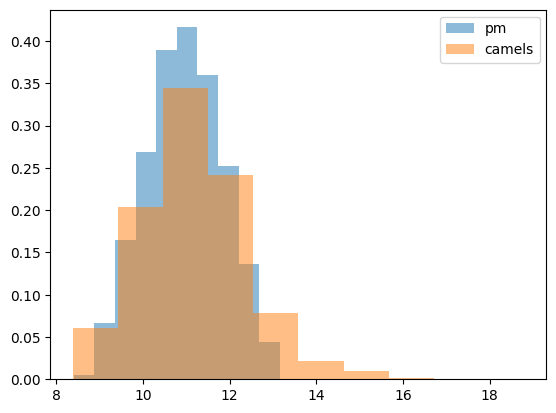

In [49]:
plt.hist(np.log10(gas_rho_pm), alpha=0.5, density=True, label="pm")
plt.hist(np.log10(gas_rho_camels), alpha=0.5, density=True, label="camels")
plt.legend()

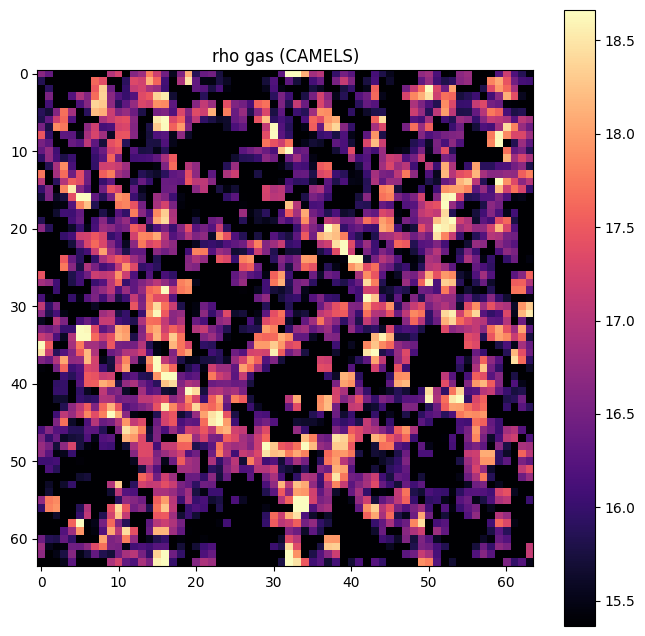

In [38]:
rho_gas_camels = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_rho_camels)

fig, ax = plt.subplots(figsize=(8,8))

# im0 = ax.imshow(np.log10(rho_gas_camels.sum(axis=0)), cmap='magma')
im0 = ax.imshow(
    np.log10(rho_gas_camels.sum(axis=0)), 
    cmap='magma',
    vmin=np.quantile(np.log10(rho_gas_camels.sum(axis=0)), 0.3),
    vmax=np.quantile(np.log10(rho_gas_camels.sum(axis=0)), 0.99),
    # vmin=0,
    # vmax=14,
)
ax.set(title='rho gas (CAMELS)')
fig.colorbar(im0, ax=ax)

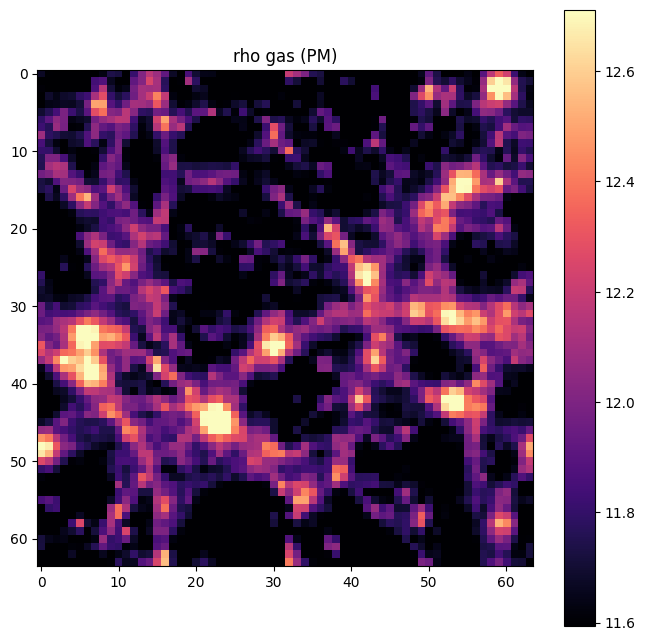

In [39]:
# rho_gas_pm_temp = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_rho_pm)

fig, ax = plt.subplots(figsize=(8,8))

# im0 = ax.imshow(np.log10(rho_gas_pm.sum(axis=0)), cmap='magma')
im0 = ax.imshow(
    np.log10(rho_gas_pm.sum(axis=0)), 
    cmap='magma',
    vmin=np.quantile(np.log10(rho_gas_pm.sum(axis=0)), 0.3),
    vmax=np.quantile(np.log10(rho_gas_pm.sum(axis=0)), 0.99),
    # vmin=0,
    # vmax=14,
)
ax.set(title='rho gas (PM)')
fig.colorbar(im0, ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

im0 = ax.imshow(np.log10(rho_gas_pm.sum(axis=0)), cmap='magma')
ax.set(title='rho gas (PM)')
fig.colorbar(im0, ax=ax)

In [41]:
gas_rho_camels/1e3

Array([4.0890460e+07, 2.5434974e+07, 1.8432022e+08, ..., 2.5755538e+12,
       2.4273203e+12, 6.4455741e+12], dtype=float32)

In [37]:
gas_rho_pm

Array([3.3720904e+07, 1.6267945e+07, 2.3721667e+08, ..., 4.5845645e+08,
       1.0444974e+08, 2.7773821e+08], dtype=float32)

# pressure (per particle vs. grid)

In [59]:
gas_P = hydro_dict["gas_Ps"]

# from the function
P_gas = cic_paint(jnp.zeros([mesh_per_dim] * 3), gas_pos, gas_P/hydro_dict["gas_rhos"])

# as described by Adrian
gamma = 5.0 / 3.0
P_weight = (gamma - 1.0) * hydro_dict["gas_Us"] * hydro_dict["gas_masss"]
P_gas_paint = cic_paint(jnp.zeros([mesh_per_dim] * 3), gas_pos, P_weight)

In [60]:
P_gas_paint

Array([[[5.5923487e+09, 5.5480095e+09, 3.1932905e+09, ...,
         3.2947625e+09, 2.2340938e+09, 2.2149350e+09],
        [1.3775031e+10, 7.4505221e+09, 3.1880868e+09, ...,
         2.9858652e+09, 3.7109898e+09, 7.8646129e+09],
        [5.9569444e+09, 2.9005617e+09, 2.1094006e+09, ...,
         9.2450335e+09, 1.1414073e+10, 1.2624202e+10],
        ...,
        [1.5992314e+09, 1.3967526e+09, 8.2703654e+08, ...,
         1.0663777e+10, 1.4196676e+10, 3.6717632e+09],
        [1.6736538e+09, 1.3233777e+09, 7.5170150e+08, ...,
         5.7805783e+09, 4.3580216e+09, 2.0845318e+09],
        [1.9935281e+09, 1.8978863e+09, 1.2167101e+09, ...,
         3.7043615e+09, 2.9756749e+09, 2.0031770e+09]],

       [[7.7568041e+09, 5.8504940e+09, 2.6553994e+09, ...,
         5.0887967e+09, 2.8237507e+09, 3.7226368e+09],
        [5.4817597e+09, 2.8419000e+09, 2.0696604e+09, ...,
         3.6555041e+09, 4.9686554e+09, 5.2068111e+09],
        [1.5129472e+09, 1.7618353e+09, 2.1255041e+09, ...,
         4.034

In [61]:
P_gas

Array([[[  421.76624 ,   422.4232  ,   261.8775  , ...,   263.29065 ,
           170.08633 ,   152.31544 ],
        [ 1139.1323  ,   572.6373  ,   256.3952  , ...,   213.92892 ,
           285.77307 ,   627.4373  ],
        [  454.58423 ,   222.92438 ,   167.12785 , ...,   774.9249  ,
           937.6101  ,  1031.6489  ],
        ...,
        [  123.978615,   116.3974  ,    65.49568 , ...,   869.3039  ,
          1130.6758  ,   265.38193 ],
        [  135.61917 ,   108.66795 ,    58.77774 , ...,   448.02542 ,
           339.41516 ,   167.3     ],
        [  157.01346 ,   144.85335 ,    93.9925  , ...,   304.5092  ,
           242.09862 ,   160.0198  ]],

       [[  632.4139  ,   472.6813  ,   207.64696 , ...,   395.55402 ,
           215.21848 ,   292.14948 ],
        [  448.20377 ,   223.53477 ,   148.9166  , ...,   278.74008 ,
           415.2979  ,   424.0241  ],
        [  115.13189 ,   145.25778 ,   164.84451 , ...,   318.1803  ,
           291.06772 ,   150.49197 ],
        ...,


In [5]:
# per particle pressure from CAMELS in units of (Msun/h)*(km/s)^2/(Mpc/h)^3
gas_P_camels = hydro_dict["gas_Ps"]

(array([2.62129e+05, 4.00000e+00, 2.00000e+00, 4.00000e+00, 2.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([8.91958067e+09, 5.05961738e+19, 1.01192348e+20, 1.51788530e+20,
        2.02384695e+20, 2.52980878e+20, 3.03577060e+20, 3.54173243e+20,
        4.04769390e+20, 4.55365573e+20, 5.05961756e+20]),
 <BarContainer object of 10 artists>)

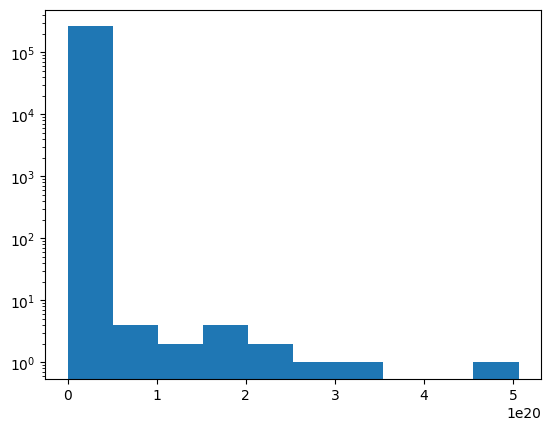

In [12]:
plt.hist(gas_P_camels, log=True)

In [7]:
# PM grid pressure according to Adrian in units of (Msun/h)*(km/s)^2/(Mpc/h)^3
gamma = 5.0 / 3.0
gas_mass = hydro_dict["gas_masss"]
# cosmo = hydro_dict["cosmo"]
# gas_mass = cosmo.Omega_b / cosmo.Omega_c
P_weighting = (gamma - 1.0) * hydro_dict["gas_Us"] * gas_mass

P_gas_pm = cic_paint(jnp.zeros([mesh_per_dim] * 3), hydro_dict["gas_poss"], P_weighting)

In [13]:
gas_mass

Array([10403884. , 22129084. , 18314960. , ..., 17753970. ,  9451953. ,
        4052258.5], dtype=float32)

In [10]:
P_gas_pm

Array([[[5.58671880e+07, 1.67212976e+08, 5.23783700e+06, ...,
         0.00000000e+00, 0.00000000e+00, 4.40662960e+07],
        [8.03092240e+07, 1.88123200e+08, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.44468475e+06],
        [1.63156480e+08, 0.00000000e+00, 0.00000000e+00, ...,
         2.69573440e+08, 2.59171740e+07, 2.46154840e+07],
        ...,
        [9.19705280e+07, 3.34150060e+07, 0.00000000e+00, ...,
         0.00000000e+00, 6.19709360e+07, 1.68796128e+08],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.65684840e+07, 8.92314160e+07, 2.55360100e+07, ...,
         0.00000000e+00, 0.00000000e+00, 8.29817280e+07]],

       [[0.00000000e+00, 9.72815000e+06, 5.22078200e+06, ...,
         1.71671000e+06, 2.60814980e+07, 0.00000000e+00],
        [0.00000000e+00, 2.60730360e+07, 4.84201360e+07, ...,
         1.09368490e+07, 1.66160528e+08, 0.00000000e+00],
        [0.00000000e+00, 

# DM particles

In [4]:
hydro_dict = camels.load_CV_snapshots(
    "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0",
    mesh_per_dim,
    parts_per_dim,
    i_snapshots=[-1],
)

dm_dict = camels.load_CV_snapshots(
    "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG_DM/CV/CV_0",
    mesh_per_dim,
    parts_per_dim,
    i_snapshots=[-1],
    return_hydro=False,
)

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 1/1 [00:08<00:00,  8.28s/it]


Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG_DM/CV/CV_0/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)


loading snapshots: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


In [5]:
hydro_dict["masses"]/dm_dict["masses"]

Array([      nan, 0.8366667,       nan,       nan,       nan,       nan],      dtype=float32)

In [6]:
Oc = 0.3 - 0.049
Ob = 0.049
Oc/(Oc+Ob)

0.8366666666666667

The DM particles in the DM-only simulations weigh more than in the hydro simulations, where that weight is roughly equal to the average weight of a gas particle plus (the constant one) of a DM particle. In line with Omega CDM, matter and baryon.

# rho units (gas)

In [7]:
hydro_dict = camels.load_CV_snapshots(
    "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0",
    mesh_per_dim,
    parts_per_dim,
    i_snapshots=[-1],
    return_hydro=True,
)

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


[3.3720904e+07 1.6267946e+07 2.3721667e+08 ... 4.5845651e+08 1.0444973e+08
 2.7773821e+08]
[1.23139256e+08 7.42360880e+07 1.48857485e+09 ... 5.63187558e+09
 8.40348864e+08 2.02110234e+09]


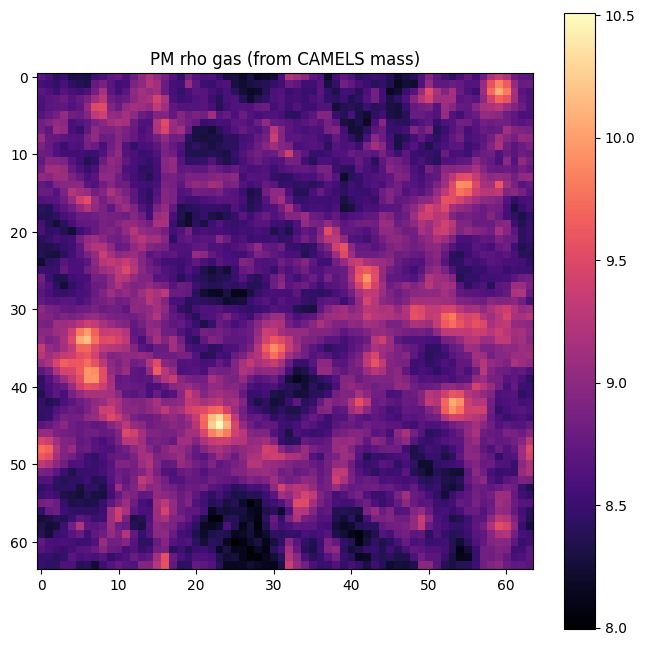

In [8]:
gas_pos = hydro_dict["gas_poss"]
gas_mass = hydro_dict["gas_masss"]
rho_gas = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_mass)

fig, ax = plt.subplots(figsize=(8,8))

im0 = ax.imshow(np.log10(rho_gas.sum(axis=0)), cmap='magma')
ax.set(title='PM rho gas (from CAMELS mass)')
fig.colorbar(im0, ax=ax)

dm_pos = hydro_dict["dm_poss"]
dm_mass = hydro_dict["masses"][1]
rho_dm = cic_paint(jnp.zeros(mesh_shape), dm_pos, dm_mass)

gas_rho = cic_read(rho_gas, gas_pos)
gas_rho_tot = gas_rho + cic_read(rho_dm, gas_pos)

print(gas_rho)
print(gas_rho_tot)

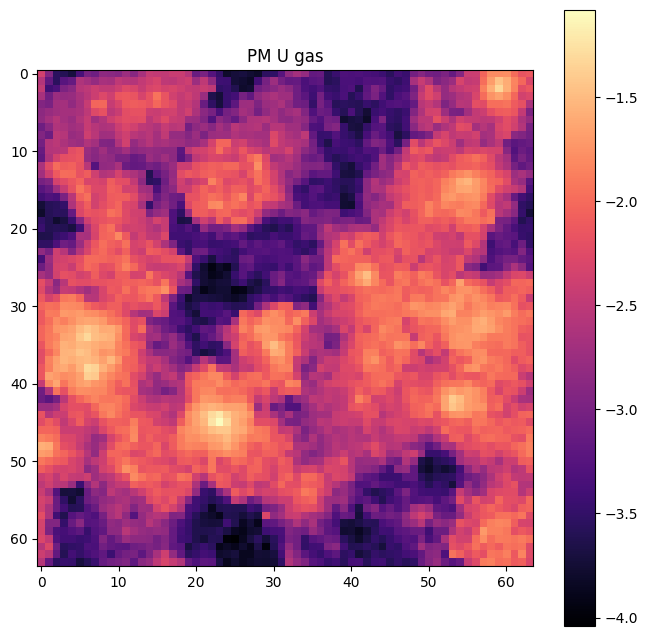

In [9]:
gas_U = hydro_dict["gas_U"]
# U = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_U)
U = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_U/gas_rho)

fig, ax = plt.subplots(figsize=(8,8))

im0 = ax.imshow(np.log10(U.sum(axis=0)), cmap='magma')
ax.set(title='PM U gas')
fig.colorbar(im0, ax=ax)


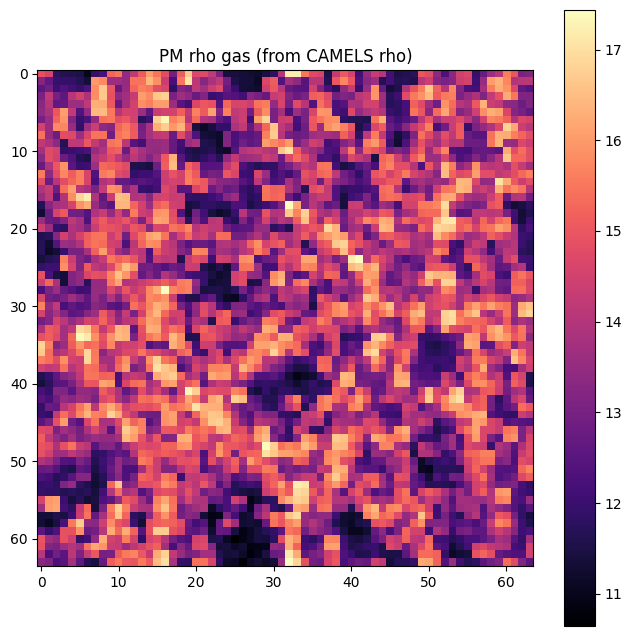

In [10]:
gas_rho_camels = hydro_dict["gas_rhos"]

rho_gas_camels = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_rho_camels)
# rho_gas_camels = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_rho_camels*gas_rho)

# rho_gas_camels /=  cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_mass)

fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(np.log10(rho_gas_camels.sum(axis=0)), cmap='magma')
ax.set(title='PM rho gas (from CAMELS rho)')
fig.colorbar(im0, ax=ax)

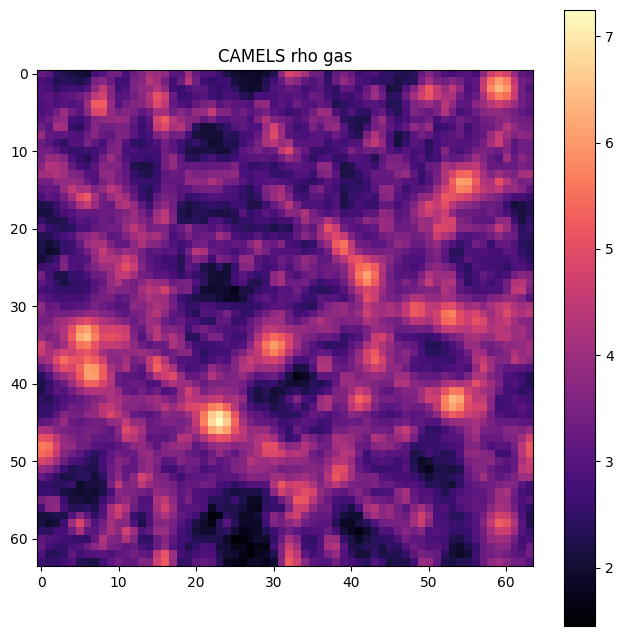

In [22]:
gas_P = hydro_dict["gas_Ps"]

fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_rhos"])
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='CAMELS rho gas')
fig.colorbar(im0, ax=ax)

### rho from positions

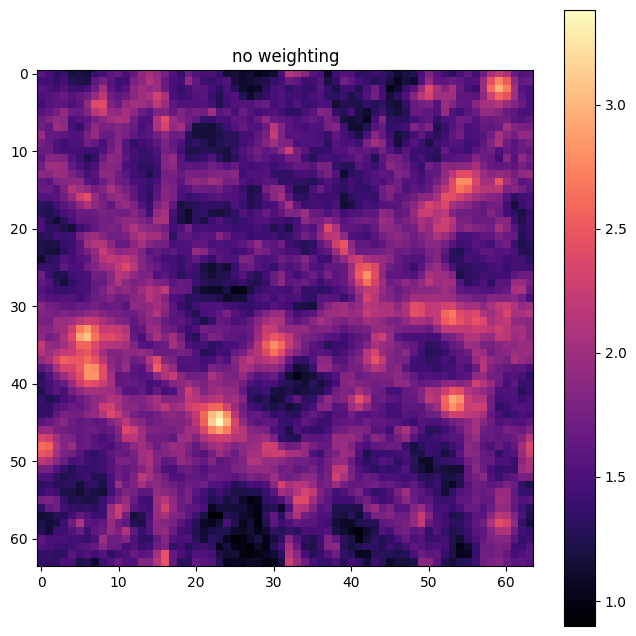

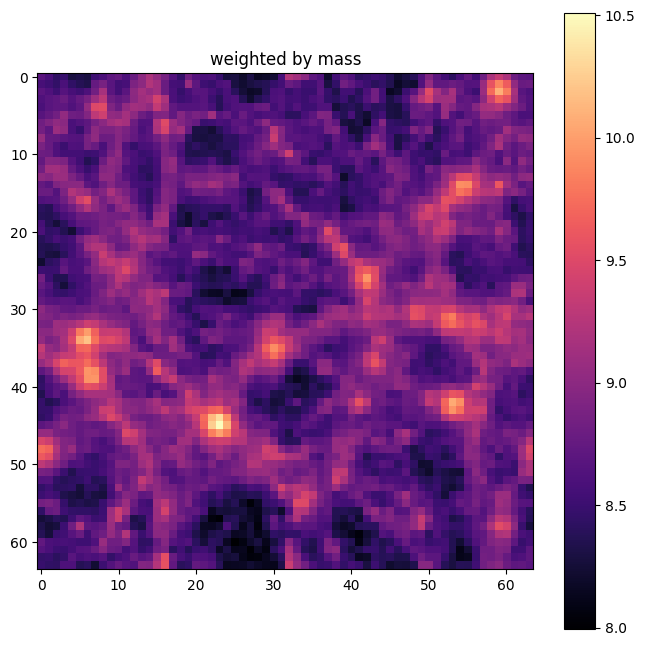

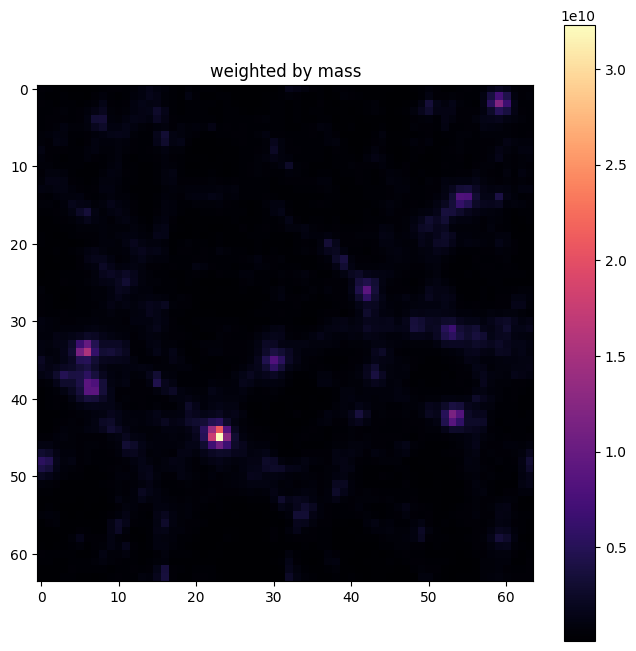

In [12]:
gas_pos = hydro_dict["gas_poss"]
gas_mass = hydro_dict["gas_masss"]
rho_gas = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_mass)
gas_rho = cic_read(rho_gas, gas_pos)

# no weighting
fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos)
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='no weighting')
fig.colorbar(im0, ax=ax)


# weighted by mass
fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_mass)
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='weighted by mass')
fig.colorbar(im0, ax=ax)

fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_mass)
    .sum(axis=0), cmap='magma'
)
ax.set(title='weighted by mass')
fig.colorbar(im0, ax=ax)

# # weighted by rho
# fig, ax = plt.subplots(figsize=(8,8))
# im0 = ax.imshow(
#     np.log10(
#         cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_rho)
#         .sum(axis=0)
#     ), cmap='magma'
# )
# ax.set(title='weighted by rho')
# fig.colorbar(im0, ax=ax)

### CAMELS internal rho

In [ ]:
rho_gas_camels_15 = cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_rhos"]**(1/15))
rho_gas_camels_15/rho_gas

(array([6.9730e+03, 2.1565e+04, 3.5406e+04, 5.0175e+04, 6.0663e+04,
        5.8643e+04, 2.5080e+04, 3.1410e+03, 4.4400e+02, 5.4000e+01]),
 array([-5.70473385, -5.36291456, -5.02109575, -4.67927647, -4.33745766,
        -3.99563837, -3.65381932, -3.31200027, -2.97018123, -2.62836218,
        -2.28654313]),
 <BarContainer object of 10 artists>)

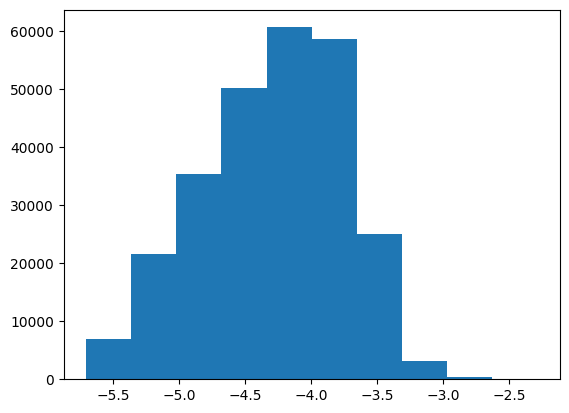

In [24]:
plt.hist(np.log10(hydro_dict["gas_rhos"]**(1/3)/gas_rho))

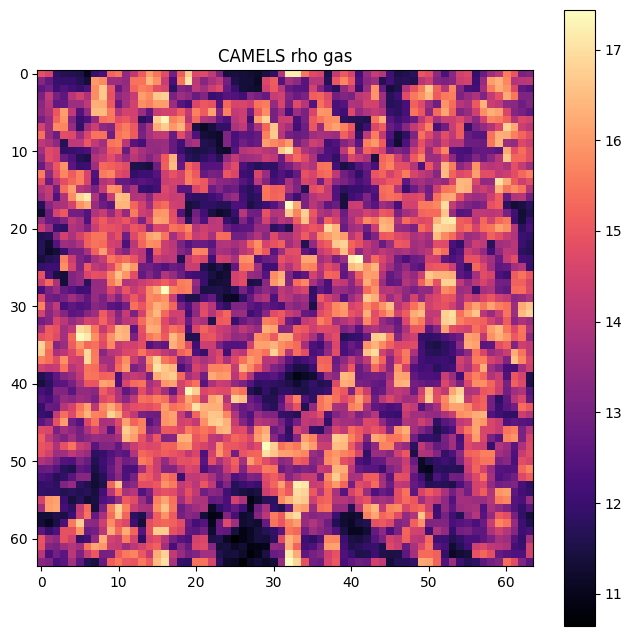

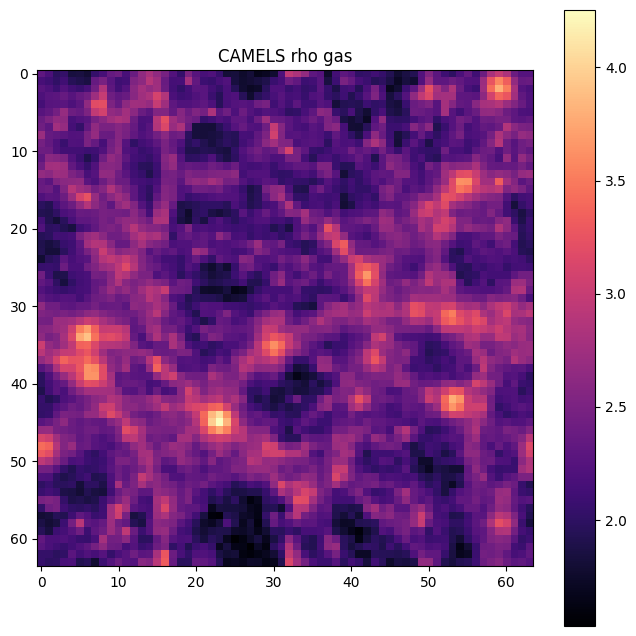

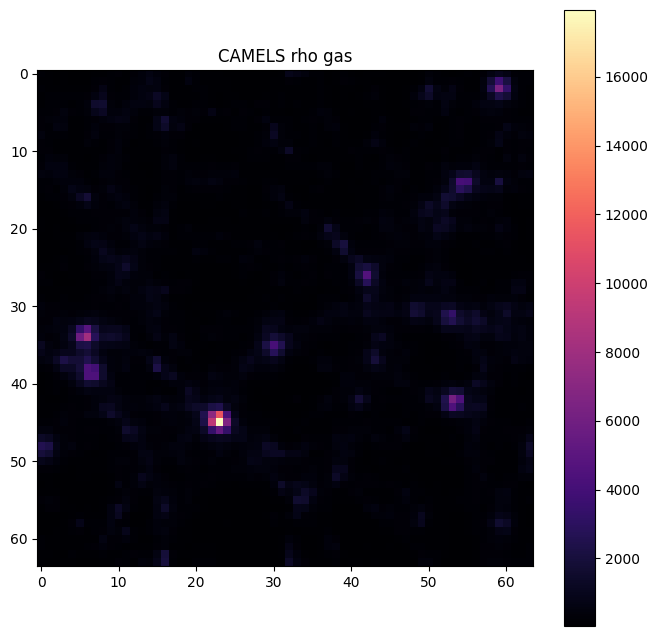

In [15]:
# not normalized
fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_rhos"])
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='CAMELS rho gas')
fig.colorbar(im0, ax=ax)


# # normalized
# fig, ax = plt.subplots(figsize=(8,8))
# im0 = ax.imshow(
#     np.log10(
#         cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_rhos"])
#         .sum(axis=0)
#     ), cmap='magma'
# )
# ax.set(title='CAMELS rho gas')
# fig.colorbar(im0, ax=ax)

# ^(1/15)
fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_rhos"]**(1/15))
        # cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_rhos"]**(1/2))
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='CAMELS rho gas')
fig.colorbar(im0, ax=ax)

fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_rhos"]**(1/15))
        .sum(axis=0), cmap='magma'
)
ax.set(title='CAMELS rho gas')
fig.colorbar(im0, ax=ax)

# # not normalized
# fig, ax = plt.subplots(figsize=(8,8))
# im0 = ax.imshow(
#     np.log10(
#         cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_masss"])
#         .sum(axis=0)
#     ), cmap='magma'
# )
# ax.set(title='CAMELS rho gas')
# fig.colorbar(im0, ax=ax)

# # multiplied
# fig, ax = plt.subplots(figsize=(8,8))
# im0 = ax.imshow(
#     np.log10(
#         cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_rhos"]*hydro_dict["gas_masss"])
#         .sum(axis=0)
#     ), cmap='magma'
# )
# ax.set(title='CAMELS rho gas')
# fig.colorbar(im0, ax=ax)

### pressure

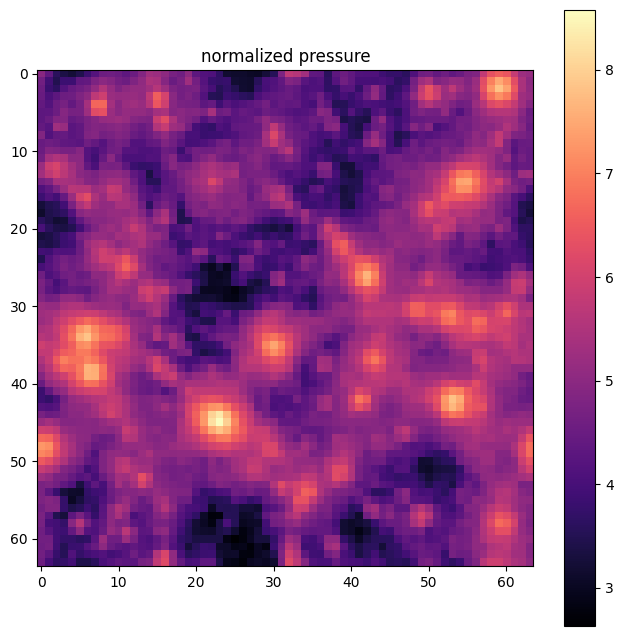

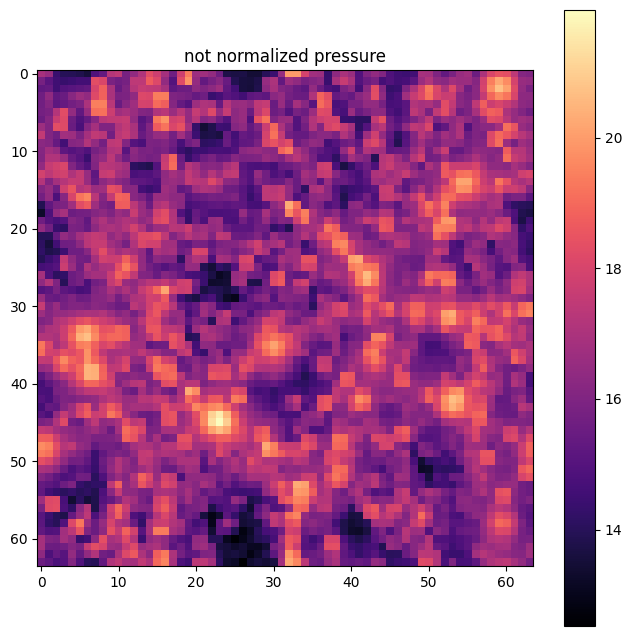

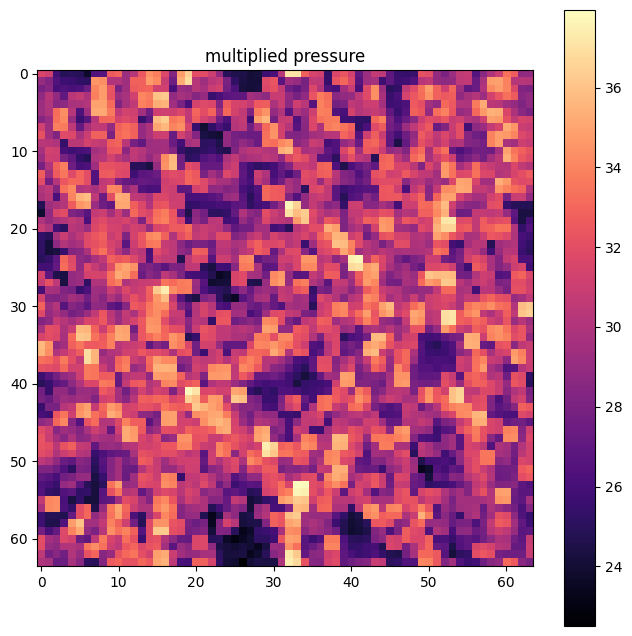

In [16]:
gas_P = hydro_dict["gas_Ps"]

# normalized
fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_Ps"]/hydro_dict["gas_rhos"])
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='normalized pressure')
fig.colorbar(im0, ax=ax)

# not normalized
fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_Ps"])
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='not normalized pressure')
fig.colorbar(im0, ax=ax)

# multiplied
fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, hydro_dict["gas_Ps"]*hydro_dict["gas_rhos"])
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='multiplied pressure')
fig.colorbar(im0, ax=ax)

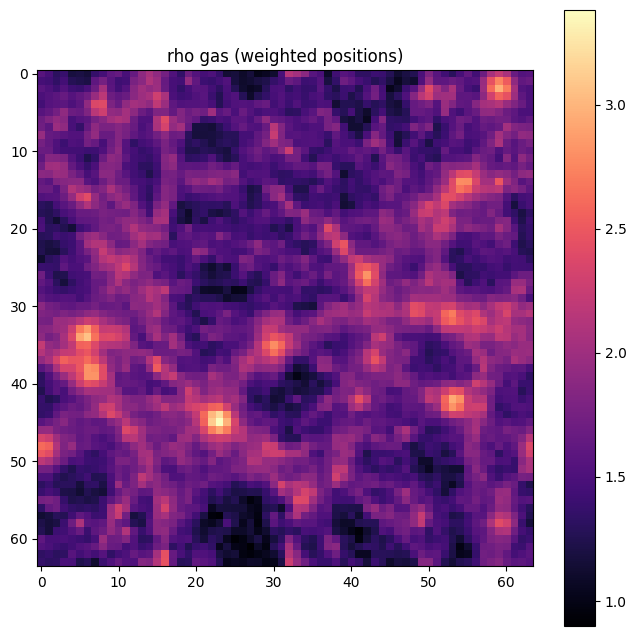

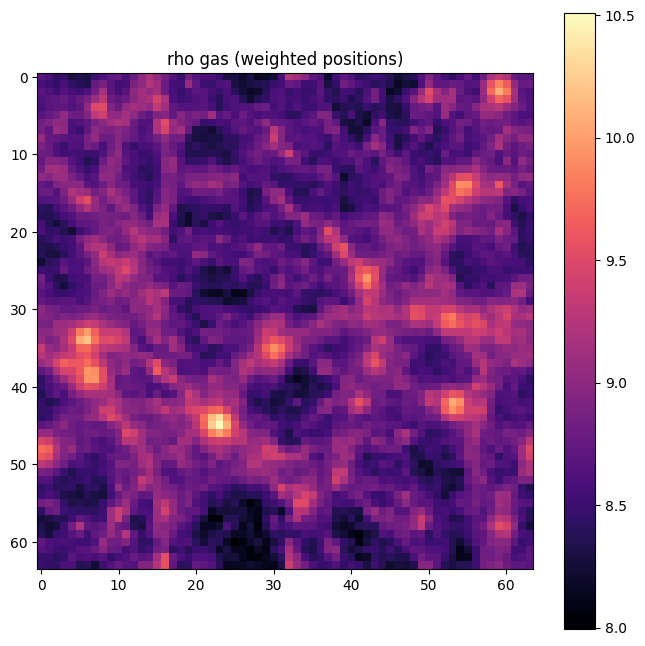

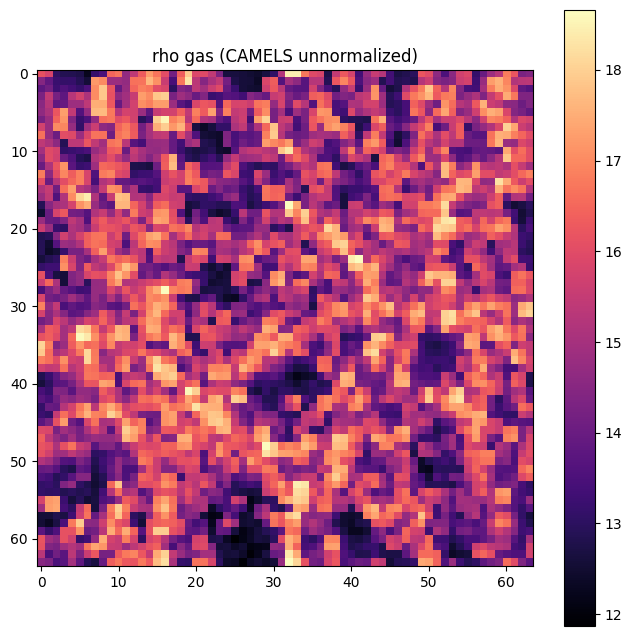

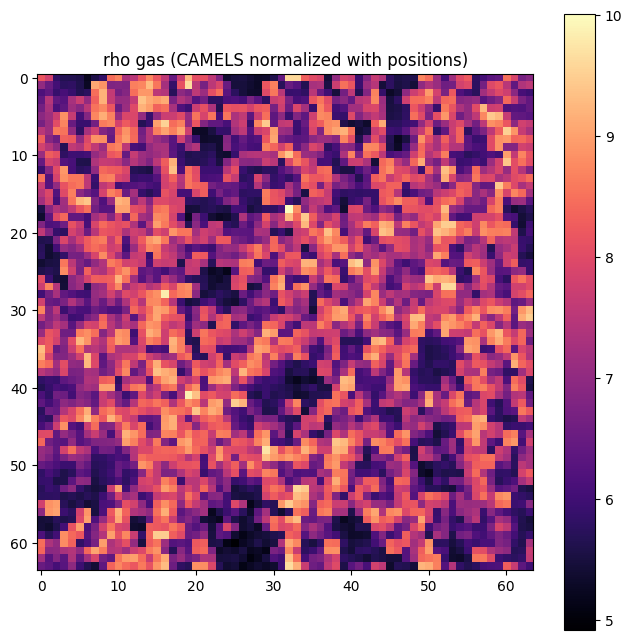

In [24]:
gas_pos = hydro_dict["gas_poss"]

rho_gas_1 = cic_paint(jnp.zeros(mesh_shape), gas_pos, 1)

fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(np.log10(rho_gas_1.sum(axis=0)), cmap='magma')
ax.set(title='rho gas (weighted positions)')
fig.colorbar(im0, ax=ax)


gas_mass = hydro_dict["gas_masss"]
rho_gas = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_mass)

fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(np.log10(rho_gas.sum(axis=0)), cmap='magma')
ax.set(title='rho gas (weighted positions)')
fig.colorbar(im0, ax=ax)



gas_rho_camels = hydro_dict["gas_rhos"]

fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_rho_camels)
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='rho gas (CAMELS unnormalized)')
fig.colorbar(im0, ax=ax)



gas_rho = cic_read(rho_gas, gas_pos)

fig, ax = plt.subplots(figsize=(8,8))
im0 = ax.imshow(
    np.log10(
        cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_rho_camels/gas_rho)
        .sum(axis=0)
    ), cmap='magma'
)
ax.set(title='rho gas (CAMELS normalized with positions)')
fig.colorbar(im0, ax=ax)

[4.0890458e+10 2.5434972e+10 1.8432021e+11 ... 2.5755536e+15 2.4273201e+15
 6.4455739e+15]


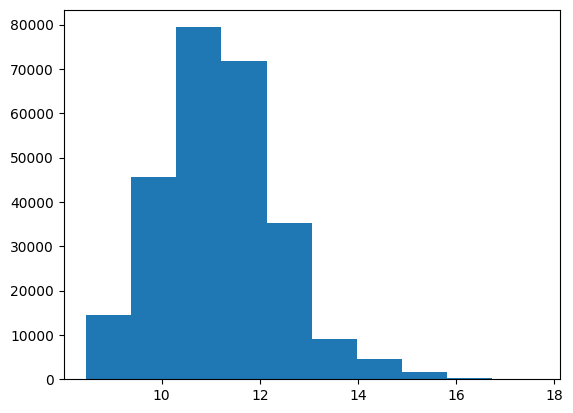

In [105]:
gas_rho_camels = hydro_dict["gas_rhos"]
plt.hist(np.log10(gas_rho_camels))
print(gas_rho_camels)

In [103]:
rho_gas_camels = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_rho_camels)
gas_rho_camels_2 = cic_read(rho_gas_camels, gas_pos)

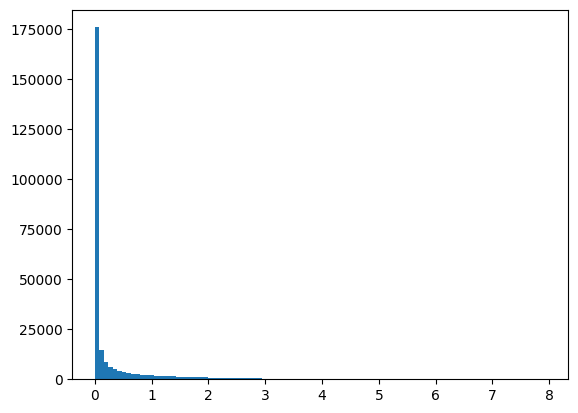

In [64]:
plt.hist(gas_rho_camels / gas_rho_camels_2, bins=100);

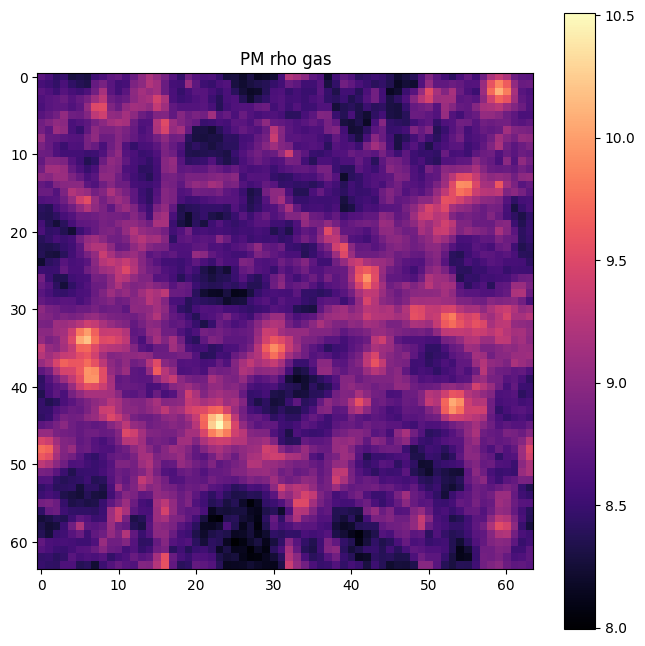

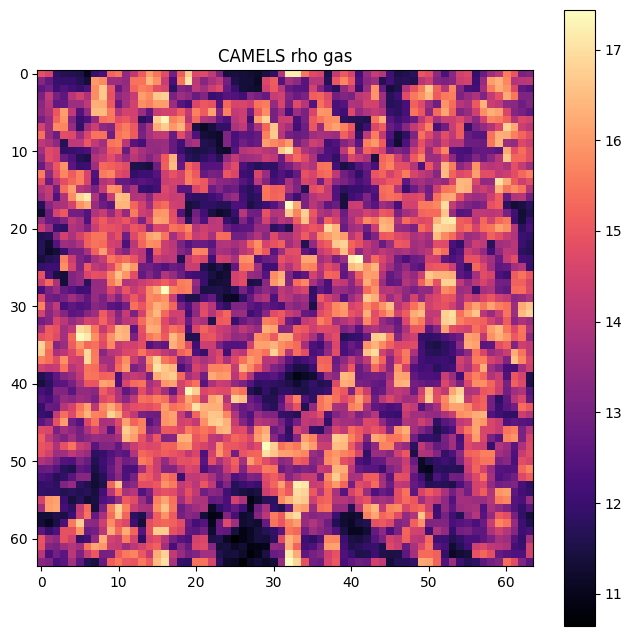

In [106]:
fig, ax = plt.subplots(figsize=(8,8))

im0 = ax.imshow(np.log10(rho_gas.sum(axis=0)), cmap='magma')
ax.set(title='PM rho gas')
fig.colorbar(im0, ax=ax)

fig, ax = plt.subplots(figsize=(8,8))

# rho_gas_camels = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_rho_camels)
# rho_gas_camels = cic_paint(jnp.zeros(mesh_shape), gas_pos)

im0 = ax.imshow(np.log10(rho_gas_camels.sum(axis=0)), cmap='magma')
ax.set(title='CAMELS rho gas')
fig.colorbar(im0, ax=ax)

In [66]:
gas_pos = hydro_dict["gas_poss"]
gas_mass = hydro_dict["gas_masss"]
rho_gas = cic_paint(jnp.zeros(mesh_shape), gas_pos, gas_mass)

dm_pos = hydro_dict["dm_poss"]
dm_mass = hydro_dict["masses"][1]
rho_dm = cic_paint(jnp.zeros(mesh_shape), dm_pos, dm_mass)

gas_rho = cic_read(rho_gas, gas_pos)
gas_rho_tot = gas_rho + cic_read(rho_dm, gas_pos)

print(gas_rho)
print(gas_rho_tot)

[3.3720904e+07 1.6267945e+07 2.3721667e+08 ... 4.5845648e+08 1.0444973e+08
 2.7773818e+08]
[1.23139256e+08 7.42360880e+07 1.48857498e+09 ... 5.63187558e+09
 8.40348928e+08 2.02110259e+09]


In [67]:
gas_rho/gas_rho_camels_2

Array([2.3264134e-04, 3.1568922e-04, 4.5461068e-08, ..., 1.0422628e-07,
       1.5042144e-07, 8.6194298e-08], dtype=float32)

(array([ 1337., 18553., 34037., 43750., 48759., 42188., 34652., 21492.,
        12840.,  4536.]),
 array([ 6.06080866,  6.46920681,  6.87760448,  7.28600264,  7.69440079,
         8.10279846,  8.51119709,  8.91959476,  9.32799244,  9.73639107,
        10.14478874]),
 <BarContainer object of 10 artists>)

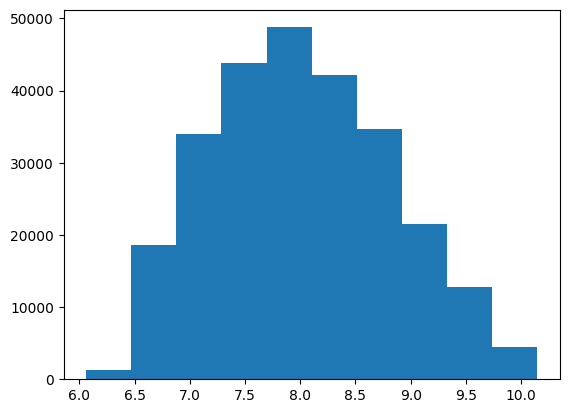

In [57]:
plt.hist(np.log10(gas_rho))

In [38]:
gas_rho_tot

Array([1.23139256e+08, 7.42360800e+07, 1.48857485e+09, ...,
       5.63187456e+09, 8.40348800e+08, 2.02110259e+09], dtype=float32)

In [40]:
gas_rho_camels / gas_rho

Array([1.2126145e+03, 1.5635023e+03, 7.7701202e+02, ..., 5.6178800e+06,
       2.3239124e+07, 2.3207370e+07], dtype=float32)

In [41]:
gas_rho_camels / gas_rho_tot

Array([3.3206680e+02, 3.4262277e+02, 1.2382328e+02, ..., 4.5731728e+05,
       2.8884675e+06, 3.1891375e+06], dtype=float32)

# CAMELS library vs. .h5

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import camels_library as cl

# snapshot name
snapshot = '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5'

# compute gas pressure in unit of (Msun/h)*(km/s)^2/(kpc/h)^3
P = cl.pressure(snapshot)

In [3]:
P*1e9

array([4.9184753e+19, 5.4594851e+19, 5.3722261e+19, ..., 1.6462426e+13,
       1.5146539e+13, 7.0536157e+15], dtype=float32)

In [6]:
from jaxpm import camels

hydro_dict = camels.load_CV_snapshots(
    "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0",
    mesh_per_dim,
    # parts_per_dim,
    i_snapshots=[-1],
    return_hydro=True,
)

# (Msun/h)*(km/s)^2/(Mpc/h)^3
my_P = hydro_dict["gas_Ps"]

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5']
Using all particles


loading snapshots:   0%|          | 0/1 [00:00<?, ?it/s]

<KeysViewHDF5 ['Coordinates', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities']>


loading snapshots: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]
2024-12-06 01:24:39.096482: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
my_P

Array([5.4079205e+17, 6.0027672e+17, 5.9068245e+17, ..., 1.8100629e+11,
       1.6653795e+11, 7.7555323e+13], dtype=float32)